# Kaggle Competition: Uc3m Machine Learning Challenge

- David Campos Brandao: 
   - github: dcamposb 
   - email: davidcamposbrandao@gmail.com 

This is a notebook detailing the code used for a Kaggle Competition I participated in 2019. The competition was created by our Machine Learning professor: Dr. Pablo Martinez Olmos (a professor for the Masters in Big Data Analytics at Universidad Carllos III in Madrid).

In the original submission I ranked 25th in the 70 competitor pool. I am revisiting the code and **updating it for my github repository**. I am also making changes as I see fit, to improve the code with things I have learned since then. I will post the new ranking.

I collaborated with **Yolanda Ibañez Perez** for the original competition. She is responsible for the first iteration of said code in 2019. While the code has changed much since then, credit is awarded.

- her linkedin: https://www.linkedin.com/in/yolanda-ib%C3%A1%C3%B1ez-p%C3%A9rez-3ab648135/

### Import Modules 

In [2]:
# Data Proccesing 
import pandas as pd 
import numpy as np 

# Sklearn Imports for Machine Learning 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns 

### Data Exploration

In the following section I will take a look at the presented data. Machine Learning can be reduced to simply training and validating; and subsequently selecting the best model with the best score, but data exploration is necessary to guarantee the *best* results. 

Understanding bias, distributions and feature relationships allows us to provide better interpretations  and data pipelines. 

In [60]:
train = pd.read_csv("data/TrainData.csv")
score = pd.read_csv("data/TestData_unlabeled.csv")

In [35]:
#  Features and Targets 
master_training = train[[T for T in train.columns if "Feat" in T ]]
master_target = train[[F for F in train.columns if "Class" in F]]
score_target  = score[:500]

# Redicing Data Siz ** See ReadMe For Reasons behind this cut 
master_training = master_training[:500]
master_target = master_target[:500]

### Correlation Analysis 
In this section I will evaluate correlations between features and correlation with targets. 
- There might be features that are correlated to each other, and there is an opportunity to dropp some features and reduce our learning sample. 
- There is also a posibility that the targets are correlated between themselves. This would be interestedto see, as a model could fit best for certain targets. 
- And finally there could be a **direct correlation between a target and a feature**, which could be a **bias** for a model that is to be tested with unseen targets in the competition. This could cause drops in testing accuracy

##### Feature Correlations 

The Training sample was reduced from 803 columns to 803 columns, taking into consideration correlations


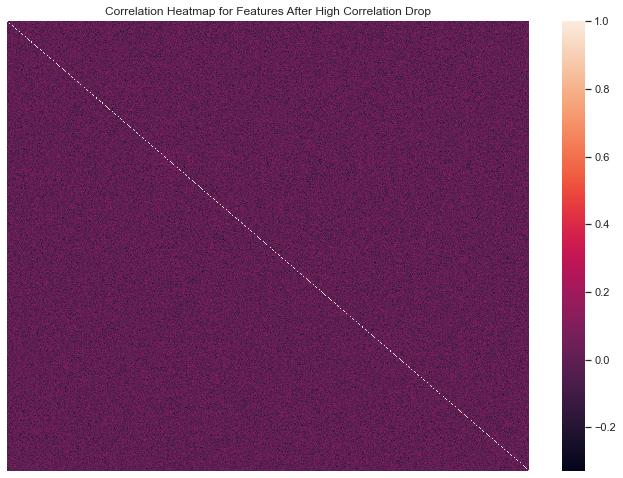

In [184]:
# Feature Correlation 
# Getting a Correlation Matrix 
# Dropping Features that are highly correlated to each Other 
def drop_corr_cols(master_training, threshold):
    """
    Function takes in a table and returns a table with the columns that are less correlated than 
    a given particular threshold. 
    
    It takes the table and a specified threshold as parameters.
    Returns a table with dropped columns that are too correlated. 
    """
    corr_matrix = master_training.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return  master_training.drop(master_training[to_drop], axis=1)

# Dropping Columns with Correlation Higher than 0.51 (51% correlation)
training_correlation_dropped = drop_corr_cols(master_training, 0.51) # anything above 5% correlation is dropped 
sns.heatmap(training_correlation_dropped.corr(), annot = False, xticklabels= False ,yticklabels = False).set_title("Correlation Heatmap for Features After High Correlation Drop")
sns.set(rc={'figure.figsize':(11.7,8.27)})
print(f"The Training sample was reduced from {master_training.shape[1]} columns to {training_correlation_dropped.shape[1]} columns, taking into consideration correlations")

#####  Target Correlations 

Lets take a look at correlation between the targets themselves. 
Since we have no idea what this datasate actually is, we can only take a look at targets and features without any description, we need to explore the data and understand the implicit relationships 


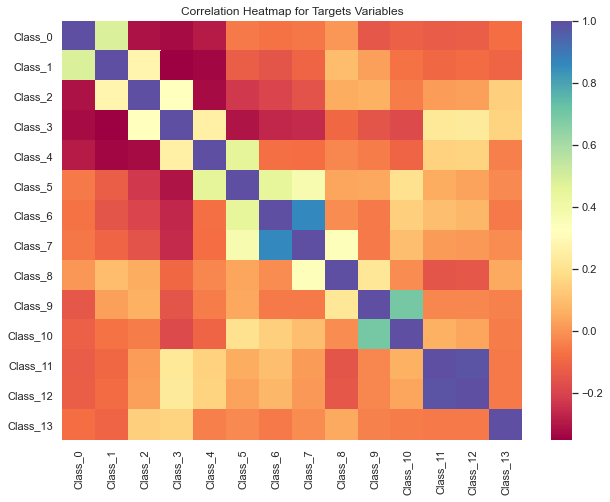

In [145]:
# Correlation Matrix for Target Columns 
master_target_corr = master_target.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(master_target_corr,  cmap="Spectral").set_title("Correlation Heatmap for Targets Variables")

**Quick notes**:
- One can see that target class 0 is negative correlated to a 20% to classes: 2,3 and 4. 
- Classes 11 and 12 are 100% correlated to each other. 
- Classes 6 and 7 are also high correlated around 80-90% 
- Classes 9 and 10 are also somewhate correlated over the 50% threshold. 

##### Correlation Between Targets and Features 

At the end of this section I want to have a list of features for each target that are highly correlated to each of the targets, I will exclude said features from the model, as they tend to be biased and tell the model the answer. 

In [146]:
# Setting Up Specific Columns to Use 
features = master_training.columns  
targets = master_target.columns 

# Making a New Table with Correlations Indexes for each Feature to Each Column 
def create_correlation_exclusion_fea_to_target_dict(train,target_columns,threshold):
    """
    Function creates a dictionary of features to exclude when predicting for a specific target 
    The purpose is to eliminate any features that might be telling the model the answer, 
    by being over correlated.  This bias could make us OVERESTIMATE the models performance. 
    
    params: 
        train: complete training set dataset 
        target_columns: target columns interested in having as keys to the dictionary 
        threshold: threshold used to calculate exclusion list 
    
    returns: 
        dictionary with exclusion lists for each class, which are the keys in the dictionary  
    """
    # Create Empty Dictionary 
    correlation_to_targets = pd.DataFrame() 
    for targets in target_columns: 
        correlation_to_targets[f"{targets}_correlation_index"] = train[train.columns[1:]].corr()[targets][:]
    
    # Creating the Exclusion Dictionary 
    exclusion_by_correlation_dict = {}

    # Storing a List of Highly Correlated Features to a Specific Column in a dictionary for future exclusion 
    for column in  correlation_to_targets.columns: 
        exclusion_list = correlation_to_targets.query(f'{column} > {threshold}').index.tolist()
        exclusion_list = [x for x in exclusion_list if x not in target_columns]
        exclusion_by_correlation_dict[column] = exclusion_list

    return exclusion_by_correlation_dict

# Execute Function 
exclusion_fea_to_target_dict = create_correlation_exclusion_fea_to_target_dict(train,targets, 0.75)

In [149]:
# Let us see that exclusion list for Features that are Over 51% correlated (either negatively of Positively) 
# Any of the targets 
exclusion_fea_to_target_dict

{'Class_0_correlation_index': [],
 'Class_10_correlation_index': [],
 'Class_11_correlation_index': [],
 'Class_12_correlation_index': [],
 'Class_13_correlation_index': [],
 'Class_1_correlation_index': [],
 'Class_2_correlation_index': [],
 'Class_3_correlation_index': [],
 'Class_4_correlation_index': [],
 'Class_5_correlation_index': [],
 'Class_6_correlation_index': [],
 'Class_7_correlation_index': [],
 'Class_8_correlation_index': [],
 'Class_9_correlation_index': []}

##### Correlation Analysis Conclusions

- In conclusion we have no high correlation between the features and the classes/targets. 
- But we do have some targets that are highly correlated to each other. 
- Also there is no high correlatio amongst the features themselves, which could allow us to do some preliminary feature reduction. 

Upon further inspection, this happens because the target is binary and the features are continous; which correlation tends to be murky when calculated

This leads me to think that 1. I should try to understand the targets a bit better. Maybe some targets are irregular in nature, meaning have no relationship or pattern to the features, and hence any model trained with said target would yield terrible results. 

Yet again the number of variables is larger than the number of instances, hence the model will have terrible results in comparison to a model that had 8000 instances (800 features x 10); which could allow us for better models and accuracies. 

### Target's Data Exploration 

#### Distribution of Binary Target Variable 

I am also interested in understanding is there is a possible imbalance between target variables, which could also bias  a model into "portraying" a good performance. 

This might happen because if a target is 80% 0's, it is easier for a model to predit 0's as much of the data are 0's themselves. A performance measurement such as the GINI, would overestimate thanks to the predominant class in the target. 

An imbalanced dataset might need some artificial imputation for the training populations, as we already have very little datat sets, we cannot trim the dominant class from the dataset, so we need to add artificial values to the non dominant class. 

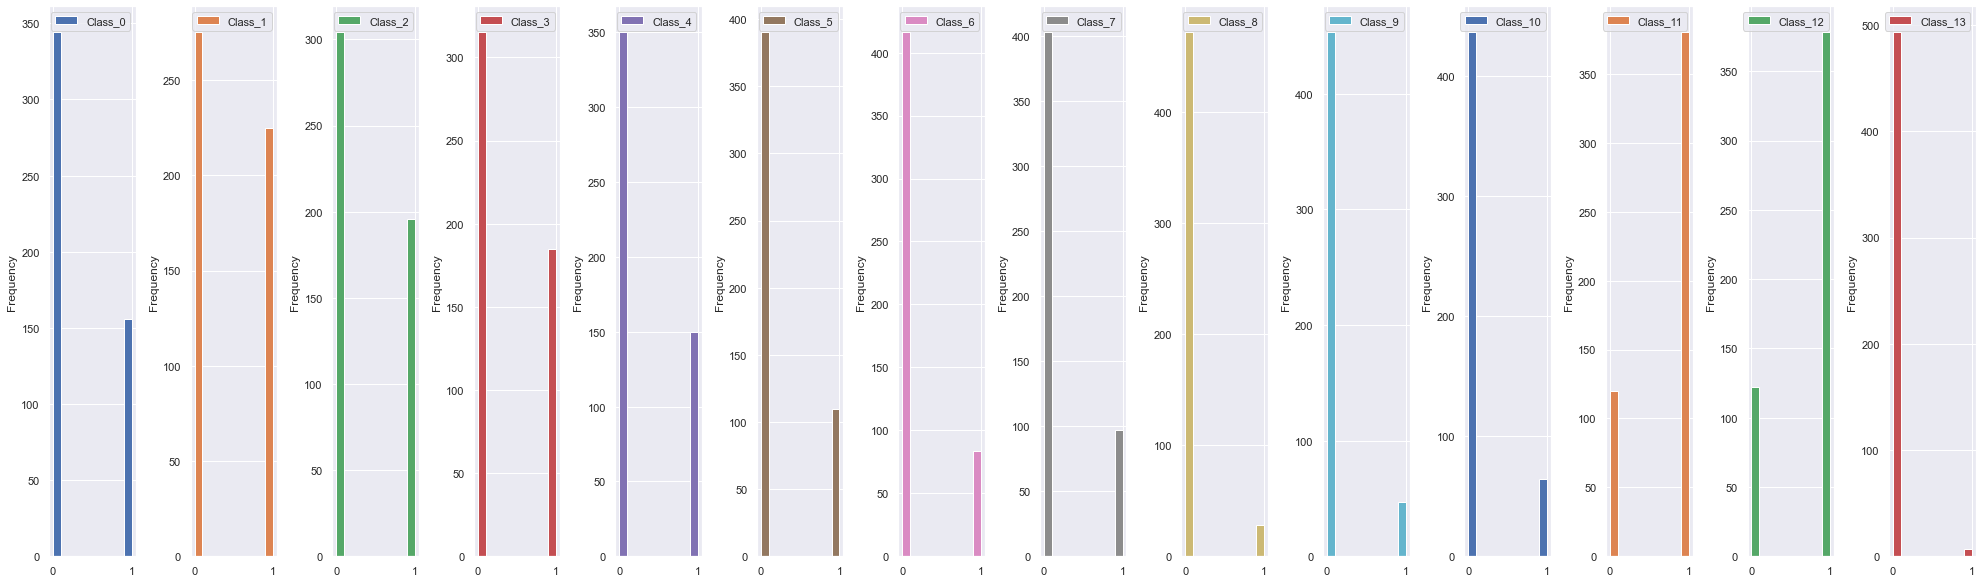

In [182]:
# Undestanding Distribution of Binary Variable Frequency 
sns.set(rc={'figure.figsize':(27.7,8.27)})
ax = master_target.plot.hist(subplots=True, legend=True, layout=(1,master_target.shape[1]))
plt.tight_layout()

##### Quick Observations: 
- One can see Classes 6, 8, 9 and 13  have sever imbalances in their target samples. 
- One can see the high correlation between certain classes illustrated here, as with Classes 11 and 12. 
    - The same observation applies for Classes 1, 2, 3 and 4


### Feature Data Exploration 

#### Proportion of Nulls for Each Feature

In [207]:
# Create a  series for each feature column calculating percentages 

def create_table_highest_null_percentage(feature_table):
    nulls_percents = feature_table.isnull().sum() * 100 / len(feature_table)
    table_percentage_nulls = pd.DataFrame(
        {'column_name': feature_table.columns,
        'percent_missing': nulls_percents}
    )

    # Which Features Have the Highest Percent of Missing Values ? 
    return table_percentage_nulls.sort_values(['percent_missing'], ascending=[False])

# Execute Function 
create_table_with_highest_null_percentage(master_training)
# Top 20 Features with Missing Values 
table_percentage_nulls.head(10)

,column_name,percent_missing
Feat_248,Feat_248,25.6
Feat_175,Feat_175,25.2
Feat_110,Feat_110,23.4
Feat_322,Feat_322,20.8
Feat_261,Feat_261,20.6
Feat_552,Feat_552,20.4
Feat_124,Feat_124,19.2
Feat_145,Feat_145,19.2
Feat_31,Feat_31,19.2
Feat_500,Feat_500,19.0


## Pipelines for Data Transformation and Training  